_Visualizing the test loss values for the different modelling experiments in TensorBoard, you can see that the EffNetB0 model trained for 10 epochs and with 20% of the data achieves the lowest loss. This sticks with the overall trend of the experiments that: more data, larger model and longer training time is generally better._


## 9. Load in the best model and make predictions with it

Looking at the TensorBoard logs for our eight experiments, it seems experiment number eight achieved the best overall results (highest test accuracy, lowest test loss).

This is the experiment that used:

- EffNetB0
- 20% pizza, steak, sushi training data (double the original training data)
- 10 epochs (double the original training time)

We can import the best saved model by creating a new instance of EffNetB2 using the `create_effnetb2()` function and then load in the saved `state_dict()` with `torch.load()`.


In [1]:
import torch
from going_modular.utils import create_effnetb0
from going_modular.GPU_check import GPU_check


device = GPU_check()

CUDA available: True
CUDA devices: 1
Current device: 0
Device name: NVIDIA GeForce RTX 3060 Laptop GPU


In [2]:
# Setup the best model filepath
best_model_path = "models/07_effnetb0_data_20_10_epochs.pth"

# Instantiate a new instance of EffNetB0 (to load the saved state_dict() to)
best_model = create_effnetb0(device = device,
                            OUT_FEATURES= 3)

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb0 model.


<All keys matched successfully>

Best model loaded!

While we're here, let's check its filesize.

This is an important consideration later on when deploying the model (incorporating it in an app).

If the model is too large, it can be hard to deploy.


In [3]:
# Check the model file size
from pathlib import Path

# Get the model size in bytes then convert to megabytes
effnetb0_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb0_model_size} MB")

EfficientNetB2 feature extractor model size: 15 MB


Looks like our best model so far is 15 MB in size. We'll keep this in mind if we want to deploy it later on.

Time to make and visualize some predictions.

We created a `pred_and_plot_image()` function to use a trained model to make predictions on an image in [06. PyTorch Transfer Learning section 6](https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set).

And we can reuse this function by importing it from [`going_modular.going_modular.predictions.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/predictions.py) (I put the `pred_and_plot_image()` function in a script so we could reuse it).

So to make predictions on various images the model hasn't seen before, we'll first get a list of all the image filepaths from the 20% pizza, steak, sushi testing dataset and then we'll randomly select a subset of these filepaths to pass to our `pred_and_plot_image()` function.


In [4]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")



[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


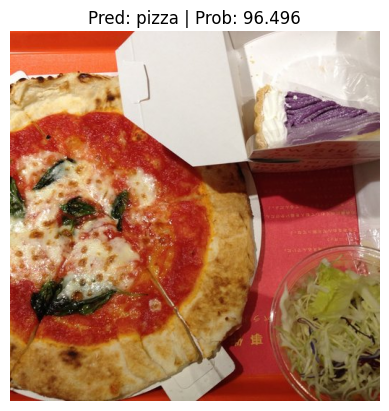

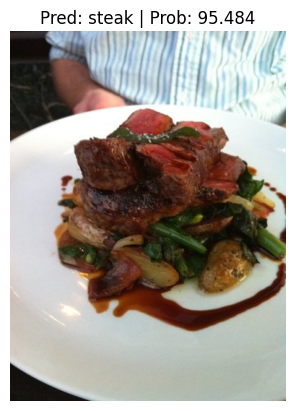

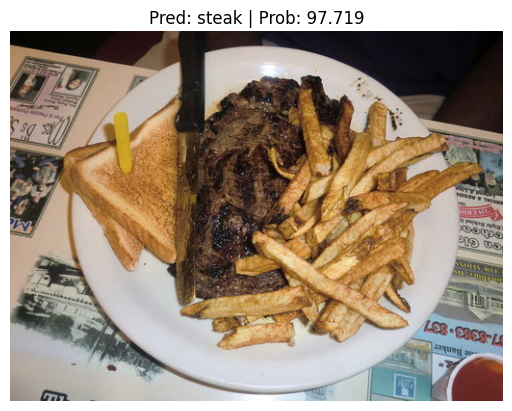

In [6]:
from going_modular.utils import pred_and_plot_image
from pathlib import Path

# Get a random list of 3 images from 20% test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg")) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=['pizza', 'steak', 'sushi'],
                        image_size=(224, 224),
                        device = device)